In [8]:
import os
import pandas as pd
import boto3
import matplotlib.pyplot as plt

In [2]:
def s3_upload(filename, backetname):
    s3 = boto3.client('s3')
    with open(filename, "rb") as f:
        s3.upload_fileobj(f, backetname, filename)

def s3_download(filename, backetname):
    s3 = boto3.client('s3')
    s3.download_file(backetname, filename, filename)

def parser_between_dates(start='1/1/2021', end='12/31/2021'):
    #створення списку потрібних дат
    df = pd.DataFrame({"date":[], 'USD':[], 'EUR':[]})
    dates = pd.Series(pd.date_range(start='1/1/2021', end='12/31/2021', freq='d'))
    dates = dates.dt.strftime('%Y%m%d')
    for date in dates:
        df_t = pd.read_json(f'https://bank.gov.ua/NBUStatService/v1/statdirectory/exchange?date={date}&json')
        df_t = pd.DataFrame({"date":df_t[df_t['cc']=="USD"]['exchangedate'].values, 'USD':df_t[df_t['cc']=="USD"]['rate'].values, 'EUR':df_t[df_t['cc']=="EUR"]['rate'].values})
        df = pd.concat([df,df_t], axis=0)

    df = df.reset_index(drop=True)
    df.to_csv("data.csv", index=False)

In [5]:
#Підготовка даних
s3 = boto3.client('s3')
results = s3.list_objects(Bucket='lkurgan', Prefix='data.csv')

try:
    s3_download('data.csv', 'lkurgan')
except:
    parser_between_dates()
    s3_upload('data.csv', 'lkurgan')

df = pd.read_csv("data.csv")

print(df.head())
print(df.tail())


         date      USD      EUR
0  01.01.2021  28.2746  34.7396
1  02.01.2021  28.2746  34.7396
2  03.01.2021  28.2746  34.7396
3  04.01.2021  28.2746  34.7396
4  05.01.2021  28.4310  34.9389
           date      USD      EUR
360  27.12.2021  27.2747  30.8450
361  28.12.2021  27.2306  30.8196
362  29.12.2021  27.2235  30.8401
363  30.12.2021  27.2077  30.7760
364  31.12.2021  27.2782  30.9226


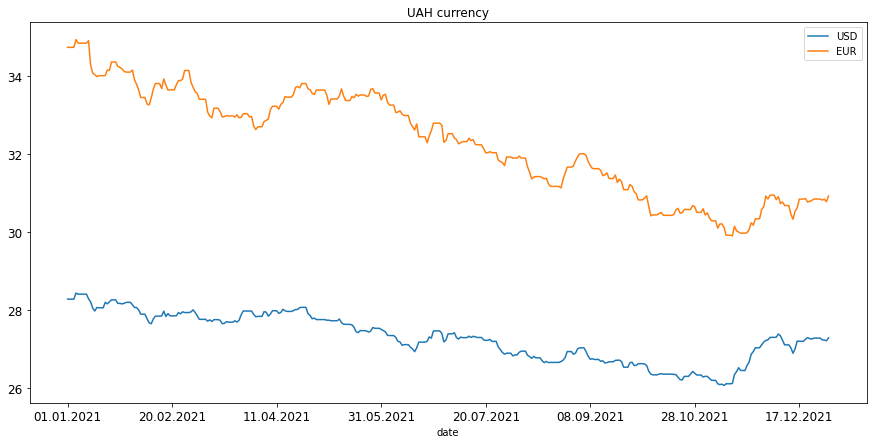

In [20]:
# створення графіку та його збереження
df.plot(x='date', y=['USD', 'EUR'], figsize=(15, 7), title="UAH currency", fontsize=12)
plt.savefig('plot.png')

In [21]:
# відправка графіку на бакет
s3_upload('plot.png', 'lkurgan')